## 0. Setting Inputs


In [1]:
target_date = "20230609"
cd_rate = 3.75

## 1. Scrape IRS data

건순 코드 참조, Jupyter Notebook에서 돌아가게끔 일부 수정

In [2]:
import asyncio
from pyppeteer import launch
from bs4 import BeautifulSoup

from collections import OrderedDict
from pprint import pprint
import pandas as pd

# avoid jupyter notebook error
import nest_asyncio
nest_asyncio.apply()

In [3]:
# IRS table getter, returns df
def _get_IRS_table(irs_table) -> pd.DataFrame:

    data_list = list()
    
    for tr in irs_table.find_all("tr"):
        # get all table rows and initialize an ordered dict to ensure sequence
        data = OrderedDict()

        for th, td in zip(irs_table.select('th'), tr.select("td")):
            # match each tr data with column heads
            data[th.text.strip()] = td.text.strip()
            
        data_list.append(data) # moved out of the loop for incremental indexing

    # Set as df and drop duplicate rows
    df = pd.DataFrame(data_list)
    df = df.drop_duplicates()
    #pprint(df)
    
    return df

In [4]:
async def main():
    browser = await launch(headless=True, autoClose=False) # headless=False : 창 안 뜸
    page = await browser.newPage()
    await page.goto('http://www.smbs.biz/Exchange/IRS.jsp')

    await page.waitFor(2000)

    await page.evaluate(f"""() => {{
        document.getElementById('searchDate').value = '';
    }}""")

    elements = await page.xpath("//input[contains(@id, 'searchDate')]")
    await elements[0].click()

    await page.waitFor(1000)
    await page.type("#searchDate", target_date) 

    await page.waitFor(1000)
    elements = await page.xpath("//img[contains(@alt, '조회하기')]")
    await elements[0].click()
    
    # Wait for the browser to navigate
    await page.waitForNavigation()
    
    html = await page.content()
    #await browser.close()
    
    return html

In [5]:
html_response = asyncio.run(main())

# Parse HTML Response with BeautifulSoup
soup = BeautifulSoup(html_response, "html.parser")

# Isolate IRS table from other data
irs_table = soup.find_all("div", attrs={"class" : "table_type2"})[0]

# Retrieve date data
search_date = soup.find("input", attrs={"name" : "StrSchFull3"})
print(f"date = {search_date.get('value')}")

df = _get_IRS_table(irs_table)
df = df.iloc[1:].reset_index(drop=True) # drop first row (null)

pprint(df)

date = 2023.06.09
     기일물 Receive     Mid     Pay
0     6M  3.7925  3.7875  3.7825
1     9M  3.7900  3.7850  3.7800
2     1Y  3.7450  3.7400  3.7350
3   1.5Y  3.6575  3.6525  3.6475
4     2Y  3.5650  3.5600  3.5550
5     3Y  3.4525  3.4475  3.4425
6     4Y  3.3925  3.3875  3.3825
7     5Y  3.3525  3.3475  3.3425
8     6Y  3.3400  3.3350  3.3300
9     7Y  3.3275  3.3225  3.3175
10    8Y  3.3275  3.3225  3.3175
11    9Y  3.3250  3.3200  3.3150
12   10Y  3.3275  3.3225  3.3175
13   12Y  3.3400  3.3350  3.3300
14   15Y  3.3325  3.3275  3.3225
15   20Y  3.2925  3.2875  3.2825


## 2. Forward Rate Table

1. IRS 'spot' 데이터 추출
2. Linear interpolation을 통해 3개월 단위 spot 계산
3. tenor별 discount factor / zero rate / implied forward rate 도출

In [6]:
import pandas as pd
from pandas import to_datetime
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# convert the search date to pandas dataframe
search_date = to_datetime(search_date.get('value'),format="%Y.%m.%d")
print(search_date)

2023-06-09 00:00:00


In [8]:
# Convert columns to float data type
df.iloc[:, 1:4] = df.iloc[:, 1:4].astype(float)

# Adjust the string tenors to float values
def convert_tenor(tenor):
    if tenor == '6M':
        return 0.5
    elif tenor == '9M':
        return 0.75
    else:
        return float(tenor[:-1])

df['tenor'] = df['기일물'].apply(convert_tenor)
print(df)

     기일물 Receive     Mid     Pay  tenor
0     6M  3.7925  3.7875  3.7825   0.50
1     9M    3.79   3.785    3.78   0.75
2     1Y   3.745    3.74   3.735   1.00
3   1.5Y  3.6575  3.6525  3.6475   1.50
4     2Y   3.565    3.56   3.555   2.00
5     3Y  3.4525  3.4475  3.4425   3.00
6     4Y  3.3925  3.3875  3.3825   4.00
7     5Y  3.3525  3.3475  3.3425   5.00
8     6Y    3.34   3.335    3.33   6.00
9     7Y  3.3275  3.3225  3.3175   7.00
10    8Y  3.3275  3.3225  3.3175   8.00
11    9Y   3.325    3.32   3.315   9.00
12   10Y  3.3275  3.3225  3.3175  10.00
13   12Y    3.34   3.335    3.33  12.00
14   15Y  3.3325  3.3275  3.3225  15.00
15   20Y  3.2925  3.2875  3.2825  20.00


In [9]:
# Create a new DataFrame with desired index
new_df = pd.DataFrame(index=np.arange(0.25, 2.25, 0.25))
new_df = new_df.merge(df[['tenor', 'Mid']], how='left', left_index=True, right_on='tenor')
new_df.set_index('tenor', inplace=True)
new_df.columns = ['spot']

# Fill in empty spots 
new_df['spot'].fillna(cd_rate, limit=1, inplace=True)
new_df['spot'] = new_df['spot'].interpolate(method='linear')
new_df['spot'] = new_df['spot']/100

# Display the resulting DataFrame
new_df

,spot
tenor,
0.25,0.037500
0.50,0.037875
0.75,0.037850
1.00,0.037400
1.25,0.036963
1.50,0.036525
1.75,0.036063
2.00,0.035600


In [10]:
# Calculate DF, zero rate, implied forward rate
new_df.index = new_df.index.astype(float)
new_df['DF'] = 1 / (1 + new_df['spot']) ** new_df.index
new_df['zero rate'] = np.log(1 / new_df['DF']) * (1 /new_df.index)

new_df['implied forward'] = (new_df['DF'].shift(1) / new_df['DF'] - 1) * (1 / 0.25)
new_df['implied forward'].fillna(cd_rate/100, limit=1, inplace=True)

# Display the resulting DataFrame
new_df

,spot,DF,zero rate,implied forward
tenor,,,,
0.25,0.037500,0.990839,0.036814,0.037500
0.50,0.037875,0.981584,0.037175,0.037713
0.75,0.037850,0.972521,0.037151,0.037276
1.00,0.037400,0.963948,0.036718,0.035574
1.25,0.036963,0.955644,0.036296,0.034759
1.50,0.036525,0.947612,0.035874,0.033907
1.75,0.036063,0.939885,0.035427,0.032884
2.00,0.035600,0.932429,0.034981,0.031983


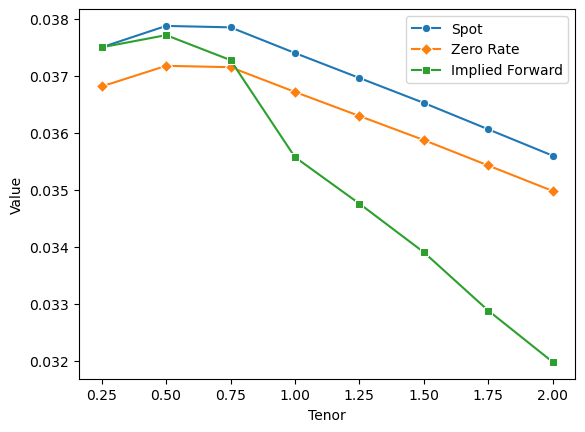

In [11]:
# Visualize using Seaborn
fig, ax = plt.subplots()

# Draw line charts for spot, zero rate, and implied forward
sns.lineplot(data=new_df['spot'], ax=ax, marker='o', label='Spot')
sns.lineplot(data=new_df['zero rate'], ax=ax, marker='D', label='Zero Rate')
sns.lineplot(data=new_df['implied forward'], ax=ax, marker='s', label='Implied Forward')

# Set the axis lables
ax.set_xlabel('Tenor')
ax.set_ylabel('Value')

# Add a legend
ax.legend()

# Show the plot
plt.show()